In [2]:
from collections import defaultdict
import csv 

import pdb
import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
import nltk
import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

import snowball

In [3]:
# all data
tweet_data = pd.read_csv("CancerReport-clean-all-data-en.txt", delimiter="\t", low_memory=False)

In [4]:
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist())) 

In [5]:
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)

In [6]:
# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
retweet_counts.extend([0]*primary_tweets.shape[0])
f = lambda x : x if x <= 25 else 26
clipped_retweet_counts = [f(n) for n in retweet_counts]

[(0, 26)]

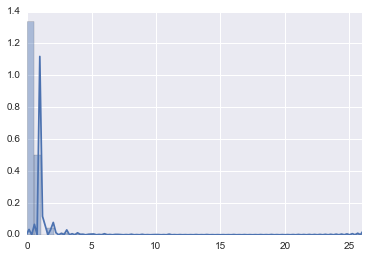

In [7]:
sns.distplot(clipped_retweet_counts).set(xlim=(0, 26))

[(0, 26)]

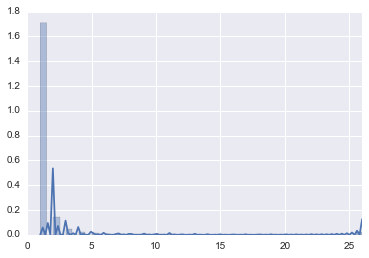

In [8]:
plt.clf()
sns.distplot([n for n in clipped_retweet_counts if n>0]).set(xlim=(0, 26))

In [9]:
### 
# now topic modeling
###

# kept_indices are the set of indices corresponding to tweets not discarded as noise 
toked_tweets, kept_indices = snowball.build_gensim_corpus(orig_tweet_texts, split_up_by_tag=False)
lda, gensim_corpus, dict_ = snowball.gen_lda_model(toked_tweets)
inferred_topic_matrix = lda.inference(gensim_corpus)[0]
# renorm, due to weirdness in gensim (???)
row_sums = inferred_topic_matrix.sum(axis=1)
inferred_topic_matrix = inferred_topic_matrix / row_sums[:, np.newaxis]

# remove the tweets that were cleaned/not included in gensim corpus
retweet_counts = [retweet_counts[idx] for idx in kept_indices]
orig_tweet_texts = [orig_tweet_texts[idx] for idx in kept_indices]


In [10]:
###
# and now regress retweet counts on inferred topic distributions (per tweet)
###

# this is just ordinary least squares (OLS)
regression_results = sm.OLS(retweet_counts, inferred_topic_matrix).fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.87
Date:                Mon, 11 Jan 2016   Prob (F-statistic):           4.50e-17
Time:                        08:33:51   Log-Likelihood:            -1.7035e+05
No. Observations:               37922   AIC:                         3.407e+05
Df Residuals:                   37912   BIC:                         3.408e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.5827      0.855      1.851      0.0

In [11]:
for topic_idx, topic in enumerate(lda.print_topics()):
    print("topic %s:\n %s\n" % (topic_idx+1, topic))

topic 1:
 0.022*every + 0.021*year + 0.019*amp + 0.019*pap + 0.014*smear + 0.013*icrc + 0.013*old + 0.013*give + 0.012*get + 0.011*young

topic 2:
 0.134*hpv + 0.101*co + 0.098*http + 0.064*vaccine + 0.028*gardasil + 0.020*girls + 0.015*vaccination + 0.013*vaccines + 0.011*via + 0.010*shot

topic 3:
 0.077*co + 0.072*http + 0.029*ecrchat + 0.016*de + 0.014*le + 0.012*phdchat + 0.009*shop + 0.009*la + 0.008*research + 0.008*gardasil

topic 4:
 0.095*mcrcomeback + 0.067*pap + 0.034*imusicrcti + 0.033*smear + 0.031*imusic_rcti + 0.028*kotakmisteriimusic + 0.025*gt + 0.025*test + 0.016*smears + 0.013*lt

topic 5:
 0.100*co + 0.095*http + 0.039*fightcancer + 0.033*colonoscopy + 0.010*amp + 0.010*today + 0.009*time + 0.009*great + 0.007*us + 0.007*ocrchat

topic 6:
 0.088*co + 0.083*http + 0.076*cancer + 0.027*prevention + 0.025*breast + 0.019*mammograms + 0.019*cervical + 0.018*free + 0.013*mammogram + 0.011*women

topic 7:
 0.052*hpv + 0.030*cancer + 0.024*cervical + 0.014*co + 0.013*sex +

In [12]:
# the below is an artifact, I think, of the issue I highlighted in the email sent 12/16/2015
top_topic_tweet_indices = inferred_topic_matrix[:,8].argsort()[-20:]
print("\n\n".join([orig_tweet_texts[idx] for idx in top_topic_tweet_indices]))

Onondaga Co. Health Department offers free cancer screenings to low-income p #BreastCancerScreening #Cancer #Women http://t.co/jtgIgPjD3y

Great news, ANZ have chosen Adelaide as the pilot location for rolling out our corporate #bowelcancer screening program http://t.co/tbihCAhP

New research: Cervical #cancer screening among young adult women in US http://t.co/8FH0slma

Thyroid Cancer Rates Are Up, But Increased Cancer Screening May Do More Harm Than Good http://t.co/250zJqFhWu #health #medical

Niagara County Department of Health: free breast and cervical cancer screening, colon cancer risk ... http://t.co/RUkxYdhBwf

Cervical cancer: the importance of regular screening – Medical News Today: The Guardian Cervical cancer: the i... http://t.co/mJzPVIRCxM

Breast cancer screening recommendations for men at higher risk are different from recommendations for women. Info at http://t.co/ebZWd0cJO3

RT @ONEinAfrica Cervical cancer is the leading cause of cancer deaths for women in Africa: ht